credit to: [笔记：hwcoder](https://hwcoder.top/Manual-Coding-1) and [知乎：论文精读之Recurrent Models of Visual Attention](https://zhuanlan.zhihu.com/p/555778029)

- Additive Attention
2014 年[《Neural Machine Translation by Jointly Learning to Align and Translate》](https://arxiv.org/abs/1409.0473)
这虽然不是最早的attention机制提出者，但是提出了注意力机制在机器翻译中的应用。
核心思想是：在生成每一个目标词时，自动对源句子的所有词分配权重（注意力），然后根据这些权重加权求和出一个“上下文向量”，作为当前步的辅助信息。

对于decoder每个时间步$i$, 有$s_{i-1}$:是上一步的hidden state (原论文的公式1)，和$\{h_1,...,h_T\}$:encoder所有时间步的hidden state(encoder输入了T个token的时候)
那么生成目标词$y_i$就需要关注这个词最应该关注原来语句中的哪些token

（原论文第七页A.2.2 decoder architecture)
第一步：计算匹配程度
对于decoder的第i步和encoder的第j步
计算decoder第i步的状态($s_{i-1}$)与 encoder第j个字符之间的关系($h_j$)
$e_{ij} = v_a^\top \tanh(W_a s_{i-1} + U_a h_j)$ 其中的$v_a^\top \in \mathbb{R}^{n'} \ \ \ \ W_a \in \mathbb{R}^{n' \times n} \ \ \ U_a \in \mathbb{R}^{n' \times 2n} $是可训练参数，$tanh$ 是激活函数。 以鄙人之见，这玩意就相当于一个一层MLP，作为Universal Approximator的，用来估计$s_{i-1}$和$h_j$的相似度的，而$s_{i-1}$代表着当前词汇的当前语境。

第二步：softmax归一化注意力权重 $\alpha_{ij}$
对于每个encoder位置j,计算一个概率权重($\alpha_{ij}$,$\sum \alpha_{ij} = 1$):
$\alpha_{ij} = \frac{\exp(e_{ij})}{\sum_{k=1}^{T_x} \exp(e_{ik})}$
就是一个softmax函数，用来1.exp放大差距2.将$e_{ij}$归一化并转换成非负权重

第三步：用注意力权重计算上下文向量$c_i$
$c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j$

$c_i$表示的是一个上下文变量，表示decoder第i个字符对于encoder中每个字符的相关度(attention值)

In [26]:
import numpy as np
np.random.seed(2025)

In [27]:
def additive_attention(s_prev,h,Wa,Ua,va):
    """
    :param s_prev: (n,)上一步decoder的hidden state (s_{j-1})
    :param h: (Tx,n)所有encoder的hidden state
    :param Wa: (d,n)s_prev的 projection matrix 
    :param Ua: (d,n)h的projection matrix
    :param va: (d,)
    :return: context:(n,)context vector c_i alpha:(Tx,)注意力权重 (Tx是输入长度,即encoder长度)
    """
    Tx,n = h.shape
    d = va.shape
    s_expanded = np.tile(s_prev,(Tx,1))
    
    e = np.tanh(s_expanded@Wa.T + h@Ua.T)@va
    # alpha_ij = softmax(e_ij)
    print(e.shape)
    alpha = np.exp(e - np.max(e))  # 避免数值不稳定
    alpha = alpha / np.sum(alpha)  # (Tx,)
    # print(alpha.shape) (Tx,n)
    # context vector c_i = sum_j alpha_ij * h_j
    print(alpha.shape,h.shape)# 输出(5,) (5, 4)
    # context = np.sum(alpha[:,np.newaxis] * h, axis=0)  # np.sum((Tx, n), axis=0) → (n,)
    context = alpha@h #(Tx,)@(Tx,n) = (n,)
    return context, alpha


def test_additive_attention():
    Tx = 5 # length of encoder
    n = 4 # hidden_size(defined in RNN/DRU/LSTM)
    d = 3 # attention dimension
    
    s_prev = np.random.randn(n)            # decoder state (n,)
    h = np.random.randn(Tx, n)             # encoder hidden states (Tx, n)
    Wa = np.random.randn(d, n)              
    Ua = np.random.randn(d, n)
    va = np.random.randn(d)
    context, alpha = additive_attention(s_prev, h, Wa, Ua, va)

    print("Context vector (c_i):", context)
    print("Attention weights (α):", alpha)
    print("Sum of attention weights:", np.sum(alpha))  # 应该接近 1
    
test_additive_attention()

(5,)
(5,) (5, 4)
Context vector (c_i): [ 0.31267093  0.54839469  0.1457593  -0.56825387]
Attention weights (α): [0.25601495 0.18044334 0.22252979 0.20301713 0.1379948 ]
Sum of attention weights: 1.0


再附赠一个pytorch版本的
这里$W_a$和$U_a$用了linear实现，支持batch操作
$$
s_{exp} \in \mathbb{R}^{batch \times T_x \times hidden} \quad \@ \quad W_a \in \mathbb{R}^{hidden \times attn}\quad \Rightarrow \quad \mathbb{R}^{batch \times T_x \times attn}
$$


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size, attention_dim):
        super().__init__()
        self.Wa = nn.Linear(hidden_size, attention_dim, bias=False)
        self.Ua = nn.Linear(hidden_size, attention_dim, bias=False)
        self.va = nn.Parameter(torch.randn(attention_dim))  # learnable vector

    def forward(self, s_prev:torch.Tensor, h):
        """
        :param s_prev: (batch, hidden_size) decoder 上一步 hidden state
        :param h: (batch, Tx, hidden_size) 所有 encoder hidden state
        :return: context: (batch, hidden_size), alpha: (batch, Tx)
        """
        # 1. expand s_prev → (batch, Tx, hidden_size)
        batch_size, Tx, _ = h.size()
        s_exp = s_prev.unsqueeze(1).expand(-1, Tx, -1)
        # s_prev (batch, hidden_size) -> unsqueeze(1) (batch, 1, hidden_size) -> expand (batch, Tx, hidden_size)
        # 所以s_exp =>(batch, Tx, hidden_size)
        # 2. 计算注意力 energy scores
        e = torch.tanh(self.Wa(s_exp) + self.Ua(h))  # (batch, Tx, attn_dim)
        e_scores = torch.matmul(e, self.va)  # (batch, Tx) (batch, Tx, attn_dim) @ (attn_dim,) → (batch, Tx)

        # 3. softmax 得到注意力分布
        alpha = F.softmax(e_scores, dim=1)  # (batch, Tx)

        # 4. 上下文向量 c_i = alpha @ h
        context = torch.bmm(alpha.unsqueeze(1), h)  # torch.bmm((batch, 1, Tx), (batch, Tx, hidden)) → (batch, 1, hidden)
        context = context.squeeze(1)  # (batch, hidden_size)

        return context, alpha
def test_torch_additive_attention():
    batch_size = 2
    Tx = 5              # encoder 时间步
    hidden_size = 4     # encoder/decoder hidden dim
    attention_dim = 3   # attention 隐空间维度

    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 随机输入：decoder state + encoder states
    s_prev = torch.randn(batch_size, hidden_size).to(device)       # (batch, hidden_size)
    h = torch.randn(batch_size, Tx, hidden_size).to(device)        # (batch, Tx, hidden_size)

    # 初始化 attention 模块
    attn = AdditiveAttention(hidden_size, attention_dim).to(device)

    # 前向计算
    context, alpha = attn(s_prev, h)

    # 输出检查
    print("s_prev shape:", s_prev.shape)
    print("h shape:", h.shape)
    print("context shape:", context.shape)  # (batch, hidden_size)
    print("alpha shape:", alpha.shape)      # (batch, Tx)
    print("alpha sum (per batch):", alpha.sum(dim=1))  # 应该接近 1
test_torch_additive_attention()

s_prev shape: torch.Size([2, 4])
h shape: torch.Size([2, 5, 4])
context shape: torch.Size([2, 4])
alpha shape: torch.Size([2, 5])
alpha sum (per batch): tensor([1., 1.], device='cuda:0', grad_fn=<SumBackward1>)


In [29]:
%reset -f

- Transformer: MHA Multi Head Attention
2017 年开山之作[《Attention is all you need》](https://arxiv.org/abs/1706.03762)所提出的一种 Attention 形式，可以说它是当前主流 LLM 的基础工作。每个头有自己单独的 Query、Key 和 Value 矩阵。


第一步： 为输入序列中计算 $Q K V$,这是通过将input tokens($X$)和project matrix( $W_q W_k W_v$ )相乘实现的
    个人认为：其中Q K是负责计算attention机制的，V是负责输出部分的
$\begin{align*}
Q &= X W_q \\
K &= X W_k \\
V &= X W_v
\text{其中：} \\
X &\in \mathbb{R}^{n \times d_{\text{model}}} \quad \text{（输入序列矩阵）} \\
W_q, W_k, W_v &\in \mathbb{R}^{d_{\text{model}} \times d_k} \quad \text{（投影矩阵）} \\
Q, K, V &\in \mathbb{R}^{n \times d_k} \quad \text{（查询、键、值向量矩阵）}
\end{align*}
$
$n$ = input sequence length
可以注意到参数中维度的$d_{model}$和$d_k$:
$d_{model}$ ->这个值指的是什么：1.从embedding角度，每一个token会被转换成一个$d_{model}$ 大小的vector 2.从计算角度，$d_{model}$不止决定了attention的结构，也和网络整体的结构参数数量有关。
定义$h$为注意力头数量，$d_k$为每个注意力头中的Query/Key向量的维度,$d_v$为Value的向量的维度,一般有：
$d_k = d_v = \frac{d_{model}}{h}$



如何从AA迁移到MHA:  $ q = W_q s_{i-1} \quad k_j = W_k h_j \quad v_j = W_v h_j$
这样看QKV就很类似了

第二步： 计算attention得分(Score)并通过softmax得到注意力分布:
和之前的additive attention机制类似，不过之前是使用MLP+tanh的方式来计算attention，再MHA中使用Scaled Dot Product来表示
Scaled Dot Product公式如下：
$\text{score}(Q, K) = \frac{Q K^\top}{\sqrt{d_k}}$
其中$d_k$是key向量的维度(通常等于每个head的维度)
这里解释一下为什么要除以$\sqrt{d_k}$:
已知（或者说假设）$q,k \in \mathbb{R}^{d_k}$每个维度都是随机初始化的，也就是说服从Standard Normal Distribution。
换句话说，$q, k \in \mathbb{R}^{d_k},\quad q_i, k_i \sim \mathcal{N}(0, 1),\quad \text{i.i.d.}$
那么对于$q \cot k$，
期望就应该是$\mathbb{E}[q \cdot k] = \sum_{i=1}^{d_k} \mathbb{E}[q_i k_i] = \sum_{i=1}^{d_k} \mathbb{E}[q_i] \mathbb{E}[k_i] = 0$
方差就应该是

$\begin{align*}
\text{Var}(q_i k_i) &= \mathbb{E}[(q_i k_i)^2] - \mathbb{E}[q_i k_i]^2 \\
&= \mathbb{E}[q_i^2] \cdot \mathbb{E}[k_i^2] - 0 \\
&= 1 \cdot 1 = 1 \\
\text{Var}[q \cdot k] &= \sum_{i=1}^{d_k} \text{Var}(q_i k_i) = \sum_{i=1}^{d_k} 1 = d_k
\end{align*}$

这就意味着attention计算出的score值会发生分布的变化,如果除以标准差$\sqrt{d_k}$就可以保持attention点积分布保持数值稳定
如果不进行这一步处理，就会让softmax接近one-hot,导致反向传播机制只关注其中一条路径，难以学习


然后再像之前AA中一样，用softmax来归一化
$\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
$

第三步：使用注意力权重加权 Value，得到上下文向量（context vector）
在AA中，我们使用了$c_i = \sum_{j=1}^{T_x} \alpha_{ij} h_j$的方法来计算context，其中的$\alpha$是attention score,$h_j$是encoder第j个token
所以在transformer中，使用Value来替代$h_j$，更好的获取局部特征
$\text{Attention}(Q, K, V) = \underbrace{\text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)}_{\text{score}} \cdot V
$
最后再concat:

$\text{MultiHeadOutput} = \text{Concat}(\cdots) W^O \in \mathbb{R}^{n \times d_{\text{model}}}\\$

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

最后，再让我们确认一下他们的维度：
$
X \in \mathbb{R}^{n \times d_{\text{model}}} \\
Q = X W_q,\quad K = X W_k,\quad V = X W_v \\
Q, K, V \in \mathbb{R}^{n \times d_k} \\
\text{score} = \frac{Q K^\top}{\sqrt{d_k}} \in \mathbb{R}^{n \times n}\\
\alpha = \text{softmax} \left( \frac{Q K^\top}{\sqrt{d_k}} \right) \in \mathbb{R}^{n \times n}\\
\text{Output} = \alpha V \in \mathbb{R}^{n \times d_v}\\
\text{Concat}(\text{head}_1, ..., \text{head}_h) \in \mathbb{R}^{n \times (h \cdot d_v)}\\
\text{MultiHeadOutput} = \text{Concat}(\cdots) W^O \in \mathbb{R}^{n \times d_{\text{model}}}\\

$

In [38]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个 head 的维度
        
        self.W_q = nn.Linear(d_model, d_model) #d_model = h * d_k ,一次性生成所有的头，再reshape成多头
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        self.W_o = nn.Linear(d_model, d_model) # concat后的那一步
    
    def forward(self,X:torch.Tensor):
        batch_size,n,_ = X.size()
        # (batch_size, seq_len, d_model) @ (d_model,d_model) ->  (batch_size, seq_len, d_model) == (batch_size, n, d_model)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)
        
        # reshape and split heads: (batch, n, d_model) -> (batch, n, num_heads, d_k) -> (batch, num_heads, n, d_k)
        Q = Q.view(batch_size, n, self.num_heads, self.d_k).transpose(1, 2)  # (B, h, n, d_k)
        K = K.view(batch_size, n, self.num_heads, self.d_k).transpose(1, 2)  # (B, h, n, d_k)
        V = V.view(batch_size, n, self.num_heads, self.d_k).transpose(1, 2)  # (B, h, n, d_k)

        # (B, h, n, d_k) @ (B, h, d_k,n) = (B, h), (n, d_k) @ (d_k, n)=> (B,h,n,n)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        alpha = F.softmax(scores,dim=-1) # 注意力权重: (batch, h, n, n) [第一个是Q的n,第二个是K的n]
        context = alpha@V # (batch, h, n, n) @ (B, h, n, d_k) = (B, h, n, d_k)
        # (B, h, n, d_k) -> (B,n,h,d_k) --contiguous()保证内存是连续的,才可以用view() -->(batch, n, d_model)
        context = context.transpose(1, 2).contiguous().view(batch_size, n, self.d_model)
        output = self.W_o(context)  # 输出线性层: (batch, n, d_model)@(d_model,d_model) ->(batch, n, d_model)

        return output, alpha
def test_multihead_attention():
    batch_size = 2
    seq_len = 5  # n
    d_model = 512
    num_heads = 8

    mha = MultiHeadAttention(d_model, num_heads)
    X = torch.randn(batch_size, seq_len, d_model)  # 模拟输入

    output, alpha = mha(X)

    print("Input shape:", X.shape)              # (2, 5, 512)
    print("Output shape:", output.shape)        # (2, 5, 512)
    print("Attention shape:", alpha.shape)      # (2, 8, 5, 5) 每个 head 都是 (n x n)

test_multihead_attention()


Input shape: torch.Size([2, 5, 512])
Output shape: torch.Size([2, 5, 512])
Attention shape: torch.Size([2, 8, 5, 5])


In [ ]:
%reset -f

padding mask:让模型跳过无意义的padding token
假设X形状为X.shape = (batch, seq_len, d_model)，那么mask应该是mask.shape = (batch, seq_len) `mask[i,j] = 1 if padding else 0`
我们将padding的score设为-infinity ,所以对应的softmax的值就会是0
```python
if padding_mask is not None:
    # padding_mask: (B, seq_len) → (B, 1, 1, seq_len) 因为score的shape是 (B,h,n,n) 这样就可以broadcast到最后一维 seq_len = n
    mask = padding_mask.unsqueeze(1).unsqueeze(1)
    scores = scores.masked_fill(mask == 1, float('-inf'))  # 用 -inf 让 softmax 输出近似 0 (B,1,1,n)-broadcast->(B,h,n,n)
```



causal mask:让模型在生成第t个token时，只能看到[0,...,t)的token
这是auto-regressive模型的要求，生成第1个token只能看到自己， 生成第2个token只能看到第一个
所以用lower-triangular matrix来做遮蔽
```text
mask = [[0, -inf, -inf],
        [0,   0,  -inf],
        [0,   0,    0]]
```
```python
# Causal mask (same for each batch/head)
if causal_mask:
    seq_len = X.size(1)
    causal = torch.triu(torch.ones(seq_len, seq_len, device=X.device), diagonal=1).bool() # (n,n)
    scores = scores.masked_fill(causal.unsqueeze(0).unsqueeze(0), float('-inf')) #(1,1,n,n) ---broadcast-->(B,h,n,n)
```


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # 每个 head 的维度

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, X, padding_mask=None, causal_mask=False):
        batch_size, seq_len, _ = X.size()

        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32, device=X.device))

        if padding_mask is not None:
            mask = padding_mask.unsqueeze(1).unsqueeze(1)  # (B, 1, 1, seq_len)
            scores = scores.masked_fill(mask == 1, float('-inf'))

        if causal_mask:
            causal = torch.triu(torch.ones(seq_len, seq_len, device=X.device), diagonal=1).bool()
            scores = scores.masked_fill(causal.unsqueeze(0).unsqueeze(0), float('-inf'))

        alpha = F.softmax(scores, dim=-1)
        context = torch.matmul(alpha, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(context)

        return output, alpha

# ============================
# 测试函数：带 padding + causal mask
# ============================
alpha = None
def test_mha_with_masks():
    global alpha
    batch_size = 2
    seq_len = 5
    d_model = 512
    num_heads = 8

    mha = MultiHeadAttention(d_model, num_heads)
    X = torch.randn(batch_size, seq_len, d_model)

    padding_mask = torch.tensor([
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1]
    ])

    output, alpha = mha(X, padding_mask=padding_mask, causal_mask=True)

    print("Output shape:", output.shape)
    print("Attention shape:", alpha.shape)
    print("Alpha (head 0, batch 0):")
    print(alpha[0, 0])


test_mha_with_masks()


Output shape: torch.Size([2, 5, 512])
Attention shape: torch.Size([2, 8, 5, 5])
Alpha (head 0, batch 0):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4691, 0.5309, 0.0000, 0.0000, 0.0000],
        [0.2790, 0.4617, 0.2593, 0.0000, 0.0000],
        [0.1647, 0.1094, 0.3599, 0.3659, 0.0000],
        [0.1848, 0.2733, 0.1857, 0.1828, 0.1733]], grad_fn=<SelectBackward0>)


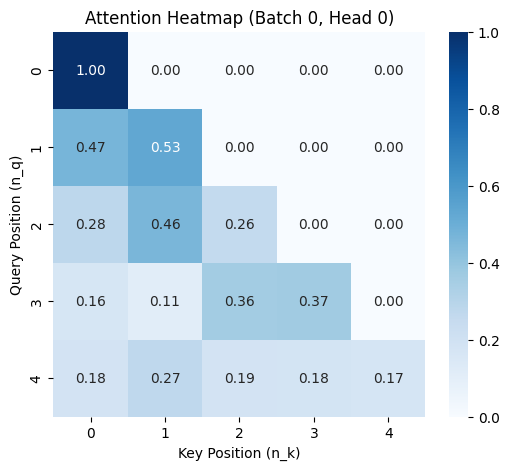

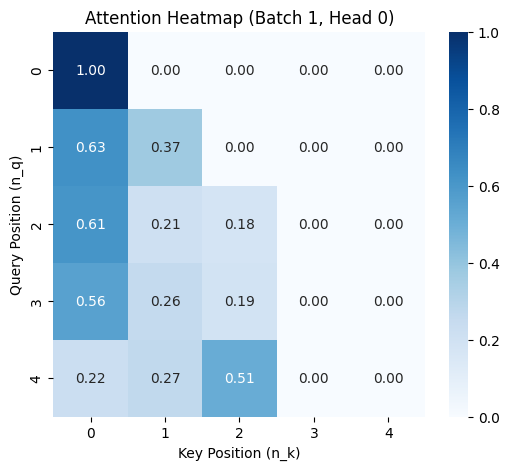

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_attention_heatmap(alpha, batch_idx=0, head_idx=0):
    # 提取对应的注意力权重矩阵
    attn = alpha[batch_idx, head_idx].detach().cpu().numpy()  # (n_q, n_k)

    plt.figure(figsize=(6, 5))
    sns.heatmap(attn, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(f"Attention Heatmap (Batch {batch_idx}, Head {head_idx})")
    plt.xlabel("Key Position (n_k)")
    plt.ylabel("Query Position (n_q)")
    plt.show()

show_attention_heatmap(alpha,0)
show_attention_heatmap(alpha,1)

第一张图说明了causal mask，只有下三角有效
第二张图说明了padding mask,在实际长度只有3，n=5时，只有前三个work